### Initial Installation

In [140]:
#installation for google colab compilations
!pip install tensorflow

In [141]:
#for local MAC
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install matplotlib
!pip install pandas

### Declaring Paths

In [142]:
!pwd

/Users/ishan/Downloads/ML_CyberSec_Lab4


In [143]:
#paths for local compilation
clean_validation_path = '/Users/ishan/Downloads/ML_CyberSec_Lab4/data/cl/valid.h5'
bad_validation_path = '/Users/ishan/Downloads/ML_CyberSec_Lab4/data/bd/bd_valid.h5'
bad_model_path ='/Users/ishan/Downloads/ML_CyberSec_Lab4/models/bd_net.h5'
evaulation_script_path = '/Users/ishan/Downloads/ML_CyberSec_Lab4/eval.py'
clean_test_path = '/Users/ishan/Downloads/ML_CyberSec_Lab4/data/cl/test.h5'
bad_test_path = '/Users/ishan/Downloads/ML_CyberSec_Lab4/data/bd/bd_test.h5'

In [144]:
# #paths for google colab compilation
# clean_validation_path= '/content/drive/MyDrive/ML_CyberSec_Lab4/data/cl/valid.h5'
# bad_validation_path = '/content/drive/MyDrive/ML_CyberSec_Lab4/data/bd/bd_valid.h5'
# bad_model_path ='/content/drive/MyDrive/ML_CyberSec_Lab4/models/bd_net.h5'
# evaulation_script_path = '/content/drive/MyDrive/ML_CyberSec_Lab4/eval.py'
# clean_test_path = '/content/drive/MyDrive/ML_CyberSec_Lab4/data/cl/test.h5'
# bad_test_path = '/content/drive/MyDrive/ML_CyberSec_Lab4/data/bd/bd_test.h5'

### Loading Data and Badnet Model

In [145]:
import h5py
import numpy as np
import tensorflow as tf


def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))  # Adjusting the shape to match TensorFlow's requirements
    return x_data, y_data

# Load the datasets
x_clean_valid, y_clean_valid = load_data(clean_validation_path)
x_bd_valid, y_bd_valid = load_data(bad_validation_path)


In [146]:
from keras.models import load_model

badnet = load_model(bad_model_path)


In [147]:
output_layer_shape = badnet.output_shape

# The number of classes (N) is the size of the last dimension of the output layer
N = output_layer_shape[-1]

print(f"The number of classes (N) is: {N}")

The number of classes (N) is: 1283


In [148]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Evaluating Badnet on test data using provided eval.py script

In [149]:
!python3 eval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-04 23:35:46.387998: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-04 23:35:46.388026: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-04 23:35:46.388034: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-04 23:35:46.388065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 23:35:46.388082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/d

#### Printing model summary so we can see the final pooling layer on which pruning is to be done

In [150]:
print(badnet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

### Pruning Defence Functions

This function prune_and_evaluate takes a backdoored neural network model and a validation dataset of clean and backdoored images. It prunes channels from the last pooling layer of the model in decreasing order of average activation values, while monitoring the impact on the model's accuracy with clean data and the attack success rate of the backdoored inputs on the model. Pruning is done until the validation accuracy drops by a specified threshold (X%). The aim is to modify the backdoored network (BadNet) into a "repaired" version that can accurately classify clean inputs while identifying backdoored inputs as a separate class. We record the accuracy and attack success rates as channels are pruned and save models that meet the specified accuracy drop thresholds.

In [151]:
from tqdm import tqdm
import keras

# Lists to store clean accuracies and attack success rates during pruning
clean_accuracies = []
attack_success_rates = []

# Function to prune the model and evaluate its performance
def prune_and_evaluate(model, cl_x_valid, cl_y_valid, bd_x_valid, bd_y_valid, clean_data_acc, thresholds):
    # Clone the model to preserve the original
    model_copy = keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())

    # Get the output of the 'pool_3' layer
    layer_output = model_copy.get_layer('pool_3').output
    intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
    intermediate_prediction = intermediate_model.predict(cl_x_valid)
    
    # Calculate the average activation values for each channel
    temp = np.mean(intermediate_prediction, axis=(0, 1, 2))
    seq = np.argsort(temp)
    weight_0, bias_0 = model_copy.layers[5].get_weights()

    # Initialize variables to track saved models
    saved_model = np.zeros(len(thresholds), dtype=bool)
    saved_models = []

    # Iterate over channels in the ascending order of average activation
    for channel_index in tqdm(seq):
        weight_0[:, :, :, channel_index] = 0
        bias_0[channel_index] = 0
        model_copy.layers[5].set_weights([weight_0, bias_0])

        # Predict on clean validation data and calculate clean accuracy
        cl_label_p = np.argmax(model_copy.predict(cl_x_valid), axis=1)
        clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100
        
        # Predict on backdoored validation data and calculate attack success rate
        bd_label_p = np.argmax(model_copy.predict(bd_x_valid), axis=1)
        attack_success_rate = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100

        # Store clean accuracy and attack success rate
        clean_accuracies.append(clean_accuracy)
        attack_success_rates.append(attack_success_rate)

        print(f"\nThe clean accuracy is: {clean_accuracy}%")
        print(f"The attack success rate is: {attack_success_rate}%")
        print(f"The pruned channel index is: {channel_index}")

        # Check if the clean accuracy drop exceeds the specified threshold
        for i, threshold in enumerate(thresholds):
            if clean_data_acc - clean_accuracy >= threshold * 100 and not saved_model[i]:
                model_name = f'pruned_model_X={threshold*100}%.h5'
                print(f"The accuracy drops at least {threshold*100}%, saving the model as {model_name}")
                model_copy.save(model_name)
                saved_model[i] = True
                saved_models.append(model_name)
                break  # Break to avoid saving at lower thresholds once a higher threshold is met

        # Clear the Keras session to release resources
        keras.backend.clear_session()

    return saved_models


### Evaluating Original Accuracy of Badnet on validation Data

In [152]:
def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    accuracy = np.mean(np.argmax(predictions, axis=1) == y_test)
    return accuracy


In [153]:
#Calculating orinal accuracy on badnet
clean_data_accuracy = evaluate_model(badnet, x_clean_valid, y_clean_valid)
print('Accuracy:{}'.format(clean_data_accuracy))

361/361 [==============================] - 3s 6ms/step
Accuracy:0.9864899974019226


### Performing channel pruning on badnet model using validation data to create pruned models

In [154]:
x_clean_test, y_clean_test = load_data(clean_test_path)
x_poisoned_test, y_poisoned_test = load_data(bad_test_path)

In [155]:
thresholds = [0.02, 0.04, 0.10]  # 2%, 4%, and 10%
pruned_models = prune_and_evaluate(badnet, x_clean_valid, y_clean_valid, x_bd_valid, y_bd_valid, clean_data_accuracy * 100, thresholds)

361/361 [==============================] - 2s 4ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 0


  2%|▏         | 1/60 [00:05<05:34,  5.67s/it]

361/361 [==============================] - 1s 4ms/step


  3%|▎         | 2/60 [00:11<05:23,  5.57s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 26
361/361 [==============================] - 1s 4ms/step


  5%|▌         | 3/60 [00:16<05:00,  5.28s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 27
361/361 [==============================] - 1s 4ms/step


  7%|▋         | 4/60 [00:21<05:00,  5.37s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 30
361/361 [==============================] - 1s 4ms/step


  8%|▊         | 5/60 [00:27<04:57,  5.40s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 31
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 33


 10%|█         | 6/60 [00:31<04:30,  5.02s/it]

361/361 [==============================] - 1s 4ms/step


 12%|█▏        | 7/60 [00:37<04:37,  5.23s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 34
361/361 [==============================] - 1s 4ms/step


 13%|█▎        | 8/60 [00:42<04:37,  5.33s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 36
361/361 [==============================] - 1s 4ms/step


 15%|█▌        | 9/60 [00:47<04:20,  5.11s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 37
361/361 [==============================] - 1s 4ms/step


 17%|█▋        | 10/60 [00:52<04:22,  5.25s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 38
361/361 [==============================] - 1s 3ms/step


 18%|█▊        | 11/60 [00:58<04:18,  5.28s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 25
361/361 [==============================] - 1s 4ms/step


 20%|██        | 12/60 [01:02<04:02,  5.06s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 39
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 41


 22%|██▏       | 13/60 [01:08<04:03,  5.19s/it]

361/361 [==============================] - 1s 4ms/step


 23%|██▎       | 14/60 [01:13<04:00,  5.23s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 44
361/361 [==============================] - 1s 3ms/step


 25%|██▌       | 15/60 [01:17<03:45,  5.00s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 45
361/361 [==============================] - 1s 4ms/step


 27%|██▋       | 16/60 [01:23<03:45,  5.12s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 47
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 48


 28%|██▊       | 17/60 [01:28<03:43,  5.19s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 49


 30%|███       | 18/60 [01:33<03:29,  4.98s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 50


 32%|███▏      | 19/60 [01:38<03:31,  5.17s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 53


 33%|███▎      | 20/60 [01:44<03:31,  5.28s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 55


 35%|███▌      | 21/60 [01:48<03:17,  5.07s/it]

361/361 [==============================] - 1s 4ms/step


 37%|███▋      | 22/60 [01:54<03:16,  5.16s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 40
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 24


 38%|███▊      | 23/60 [01:59<03:12,  5.19s/it]

361/361 [==============================] - 1s 4ms/step


 40%|████      | 24/60 [02:04<02:59,  4.98s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 59
361/361 [==============================] - 1s 4ms/step


 42%|████▏     | 25/60 [02:09<02:58,  5.09s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 9
361/361 [==============================] - 1s 3ms/step


 43%|████▎     | 26/60 [02:14<02:56,  5.19s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 2
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 12


 45%|████▌     | 27/60 [02:19<02:44,  4.97s/it]

361/361 [==============================] - 1s 4ms/step


 47%|████▋     | 28/60 [02:24<02:44,  5.15s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 13
361/361 [==============================] - 1s 4ms/step


 48%|████▊     | 29/60 [02:30<02:39,  5.16s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 17
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 14


 50%|█████     | 30/60 [02:34<02:28,  4.95s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 15


 52%|█████▏    | 31/60 [02:39<02:26,  5.04s/it]

361/361 [==============================] - 1s 4ms/step


 53%|█████▎    | 32/60 [02:44<02:22,  5.10s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 23
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 6


 55%|█████▌    | 33/60 [02:49<02:12,  4.92s/it]

361/361 [==============================] - 1s 4ms/step


 57%|█████▋    | 34/60 [02:54<02:12,  5.09s/it]


The clean accuracy is: 98.64033948211657%
The attack success rate is: 100.0%
The pruned channel index is: 51
361/361 [==============================] - 1s 4ms/step


 58%|█████▊    | 35/60 [03:00<02:10,  5.24s/it]


The clean accuracy is: 98.64033948211657%
The attack success rate is: 100.0%
The pruned channel index is: 32
361/361 [==============================] - 1s 4ms/step


 60%|██████    | 36/60 [03:04<01:59,  4.98s/it]


The clean accuracy is: 98.63167922404088%
The attack success rate is: 100.0%
The pruned channel index is: 22
361/361 [==============================] - 1s 4ms/step


 62%|██████▏   | 37/60 [03:10<01:58,  5.15s/it]


The clean accuracy is: 98.65765999826795%
The attack success rate is: 100.0%
The pruned channel index is: 21
361/361 [==============================] - 1s 4ms/step


 63%|██████▎   | 38/60 [03:15<01:55,  5.26s/it]


The clean accuracy is: 98.64899974019225%
The attack success rate is: 100.0%
The pruned channel index is: 20
361/361 [==============================] - 1s 4ms/step


 65%|██████▌   | 39/60 [03:20<01:46,  5.07s/it]


The clean accuracy is: 98.6056984498138%
The attack success rate is: 100.0%
The pruned channel index is: 19
361/361 [==============================] - 1s 4ms/step


 67%|██████▋   | 40/60 [03:26<01:45,  5.30s/it]


The clean accuracy is: 98.57105741751104%
The attack success rate is: 100.0%
The pruned channel index is: 43
361/361 [==============================] - 1s 4ms/step


 68%|██████▊   | 41/60 [03:32<01:43,  5.45s/it]


The clean accuracy is: 98.53641638520828%
The attack success rate is: 100.0%
The pruned channel index is: 58
361/361 [==============================] - 1s 4ms/step


 70%|███████   | 42/60 [03:36<01:33,  5.19s/it]


The clean accuracy is: 98.19000606218066%
The attack success rate is: 100.0%
The pruned channel index is: 3
361/361 [==============================] - 1s 4ms/step


 72%|███████▏  | 43/60 [03:42<01:29,  5.27s/it]


The clean accuracy is: 97.65307006148784%
The attack success rate is: 100.0%
The pruned channel index is: 42
361/361 [==============================] - 2s 4ms/step

The clean accuracy is: 97.50584567420108%
The attack success rate is: 100.0%
The pruned channel index is: 1


 73%|███████▎  | 44/60 [03:47<01:26,  5.39s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 95.75647354291158%
The attack success rate is: 100.0%
The pruned channel index is: 29
The accuracy drops at least 2.0%, saving the model as pruned_model_X=2.0%.h5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 75%|███████▌  | 45/60 [03:52<01:16,  5.13s/it]

361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 95.20221702606739%
The attack success rate is: 99.9913397419243%
The pruned channel index is: 16


 77%|███████▋  | 46/60 [03:58<01:13,  5.28s/it]

361/361 [==============================] - 1s 4ms/step


 78%|███████▊  | 47/60 [04:03<01:08,  5.24s/it]


The clean accuracy is: 94.7172425738287%
The attack success rate is: 99.9913397419243%
The pruned channel index is: 56
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 92.09318437689443%
The attack success rate is: 99.9913397419243%
The pruned channel index is: 46
The accuracy drops at least 4.0%, saving the model as pruned_model_X=4.0%.h5


 80%|████████  | 48/60 [04:07<01:00,  5.05s/it]

361/361 [==============================] - 1s 4ms/step


 82%|████████▏ | 49/60 [04:13<00:56,  5.17s/it]


The clean accuracy is: 91.49562656967177%
The attack success rate is: 99.9913397419243%
The pruned channel index is: 5
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 91.01931237550879%
The attack success rate is: 99.98267948384861%
The pruned channel index is: 8


 83%|████████▎ | 50/60 [04:18<00:52,  5.21s/it]

361/361 [==============================] - 1s 4ms/step


 85%|████████▌ | 51/60 [04:23<00:45,  5.03s/it]


The clean accuracy is: 89.17467740538669%
The attack success rate is: 80.73958603966398%
The pruned channel index is: 11
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 84.43751623798389%
The attack success rate is: 77.015675067117%
The pruned channel index is: 54
The accuracy drops at least 10.0%, saving the model as pruned_model_X=10.0%.h5


 87%|████████▋ | 52/60 [04:28<00:41,  5.16s/it]

361/361 [==============================] - 1s 4ms/step


 88%|████████▊ | 53/60 [04:33<00:36,  5.15s/it]


The clean accuracy is: 76.48739932449988%
The attack success rate is: 35.71490430414826%
The pruned channel index is: 10
361/361 [==============================] - 1s 4ms/step


 90%|█████████ | 54/60 [04:38<00:30,  5.01s/it]


The clean accuracy is: 54.8627349095003%
The attack success rate is: 6.954187234779596%
The pruned channel index is: 28
361/361 [==============================] - 1s 4ms/step


 92%|█████████▏| 55/60 [04:44<00:25,  5.17s/it]


The clean accuracy is: 27.08928726076037%
The attack success rate is: 0.4243526457088421%
The pruned channel index is: 35
361/361 [==============================] - 1s 4ms/step


 93%|█████████▎| 56/60 [04:49<00:20,  5.22s/it]


The clean accuracy is: 13.87373343725643%
The attack success rate is: 0.0%
The pruned channel index is: 18
361/361 [==============================] - 1s 4ms/step


 95%|█████████▌| 57/60 [04:53<00:14,  4.99s/it]


The clean accuracy is: 7.101411622066338%
The attack success rate is: 0.0%
The pruned channel index is: 4
361/361 [==============================] - 1s 4ms/step

The clean accuracy is: 1.5501861955486274%
The attack success rate is: 0.0%
The pruned channel index is: 7


 97%|█████████▋| 58/60 [04:59<00:10,  5.16s/it]

361/361 [==============================] - 1s 4ms/step


 98%|█████████▊| 59/60 [05:04<00:05,  5.17s/it]


The clean accuracy is: 0.7188014202823244%
The attack success rate is: 0.0%
The pruned channel index is: 52
361/361 [==============================] - 1s 4ms/step


100%|██████████| 60/60 [05:09<00:00,  5.15s/it]


The clean accuracy is: 0.0779423226812159%
The attack success rate is: 0.0%
The pruned channel index is: 57


In [156]:
print(pruned_models)

['pruned_model_X=2.0%.h5', 'pruned_model_X=4.0%.h5', 'pruned_model_X=10.0%.h5']


### Evaluation of the pruned models

In [157]:
# # For getting back saved models if they were saved before and evaluating
pruned_models = ['pruned_model_X=2.0%.h5', 'pruned_model_X=4.0%.h5', 'pruned_model_X=10.0%.h5']

In [158]:
# Load pruned models
loaded_pruned_models = [load_model(filename) for filename in pruned_models]

In [159]:
def evaluate_pruned_model(model, x_clean_test, y_clean_test, x_poisoned_test, y_poisoned_test):
    # Predict with pruned model on clean and poisoned test data
    clean_pred = np.argmax(model.predict(x_clean_test), axis=1)
    poisoned_pred = np.argmax(model.predict(x_poisoned_test), axis=1)

    # Calculate accuracy on clean data
    clean_accuracy = np.mean(clean_pred == y_clean_test)

    # Calculate attack success rate
    attack_success_rate = np.mean(poisoned_pred == y_poisoned_test)

    return clean_accuracy, attack_success_rate

In [160]:
pruned_model_accuracies = []
pruned_model_attack_success_rates = []

for i, model in enumerate(loaded_pruned_models):
    accuracy, attack_success_rate = evaluate_pruned_model(
        model, x_clean_test, y_clean_test, x_poisoned_test, y_poisoned_test)
    pruned_model_accuracies.append(accuracy)
    pruned_model_attack_success_rates.append(attack_success_rate)
    print(f"Pruned Model {i}: Accuracy = {accuracy*100:.2f}%, Attack Success Rate = {attack_success_rate*100:.2f}%")

401/401 [==============================] - 2s 4ms/step
Pruned Model 0: Accuracy = 95.90%, Attack Success Rate = 100.00%
401/401 [==============================] - 2s 4ms/step
Pruned Model 1: Accuracy = 92.29%, Attack Success Rate = 99.98%
401/401 [==============================] - 2s 4ms/step
Pruned Model 2: Accuracy = 84.54%, Attack Success Rate = 77.21%


### Constructing and Evaluating the goodnet models from the original badnet model and the pruned models

In [161]:
def construct_goodnet(badnet, pruned_badnet, n_classes):
    def goodnet_predict(input_data):
        # Predict using both the original and pruned models
        prediction_B = np.argmax(badnet.predict(input_data), axis=1)
        prediction_B_prime = np.argmax(pruned_badnet.predict(input_data), axis=1)

        # Compare predictions and decide the output
        output_pred = np.where(prediction_B == prediction_B_prime, prediction_B, n_classes)
        return output_pred

    return goodnet_predict



In [162]:
# Construct GoodNets with loaded models
# passing N+1 as num_classes to be returned when backdoored input is detected
goodnets = [construct_goodnet(badnet, loaded_pruned_model, N+1) for loaded_pruned_model in loaded_pruned_models]


In [163]:
def evaluate_goodnet(goodnet, x_clean_test, y_clean_test, x_poisoned_test, y_poisoned_test, n_classes):
    # Predict with GoodNet on clean and poisoned test data
    clean_pred = goodnet(x_clean_test)
    poisoned_pred = goodnet(x_poisoned_test)

    # Calculate accuracy on clean data
    clean_accuracy = np.mean(clean_pred == y_clean_test)
    attack_success_rate = np.mean(poisoned_pred == y_poisoned_test)

    return clean_accuracy, attack_success_rate


In [164]:
# Evaluate each GoodNet
goodnet_accuracies = []
goodnet_attack_success_rates = []

for i, goodnet in enumerate(goodnets):
    accuracy, attack_success_rate = evaluate_goodnet(
        goodnet, x_clean_test, y_clean_test, x_poisoned_test, y_poisoned_test, N+1
    )
    goodnet_accuracies.append(accuracy)
    goodnet_attack_success_rates.append(attack_success_rate)
    print(f"GoodNet {i}: Accuracy = {accuracy*100:.2f}%, Attack Success Rate = {attack_success_rate*100:.2f}%")


401/401 [==============================] - 1s 4ms/step
GoodNet 0: Accuracy = 95.74%, Attack Success Rate = 100.00%
401/401 [==============================] - 1s 4ms/step
GoodNet 1: Accuracy = 92.13%, Attack Success Rate = 99.98%
401/401 [==============================] - 1s 4ms/step
GoodNet 2: Accuracy = 84.33%, Attack Success Rate = 77.21%


### Functions for plotting graphs and tables

In [165]:
import matplotlib.pyplot as plt
def printAccuracyAndAttackSuccessRatesGraph(thresholds_percentages, accuracies_percentages, attack_success_rates_percentages):
    num_thresholds = len(thresholds_percentages)
    # Setting up the bar chart
    fig, ax = plt.subplots()
    index = np.arange(num_thresholds)
    bar_width = 0.2
    opacity = 0.8
    # Creating bars for accuracies and attack rates
    accuracy_bars = ax.bar(index, accuracies_percentages, bar_width,
        alpha=opacity, color='b', label='Accuracy')

    attack_rate_bars = ax.bar(index + bar_width, attack_success_rates_percentages, bar_width,
        alpha=opacity, color='r', label='Attack Success Rate')
    # Adding the text on the bars
    for bar in accuracy_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')
    for bar in attack_rate_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')
    # Adding labels, title and customizing axes
    ax.set_xlabel('Thresholds (%)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Accuracy and Attack Success Rates as Percentages for Each Threshold')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f"{thresh}" for thresh in thresholds_percentages])
    ax.legend()
    # Displaying the plot
    plt.tight_layout()
    plt.show()


In [166]:
import pandas as pd
def printResultsTable(thresholds_percentages, accuracies_percentages, attack_success_rates_percentages):
    data = {
    'Threshold (%)': thresholds_percentages,
    'Accuracy (%)': accuracies_percentages,
    'Attack Success Rate (%)': attack_success_rates_percentages
    }

    df = pd.DataFrame(data)

    print(df)

### Showing results for Goodnet Models

In [167]:
thresholds_percentages = [x * 100 for x in thresholds]

In [168]:
goodnet_accuracies_percentages = [x * 100 for x in goodnet_accuracies]
goodnet_attack_success_rates_percentages = [x * 100 for x in goodnet_attack_success_rates]

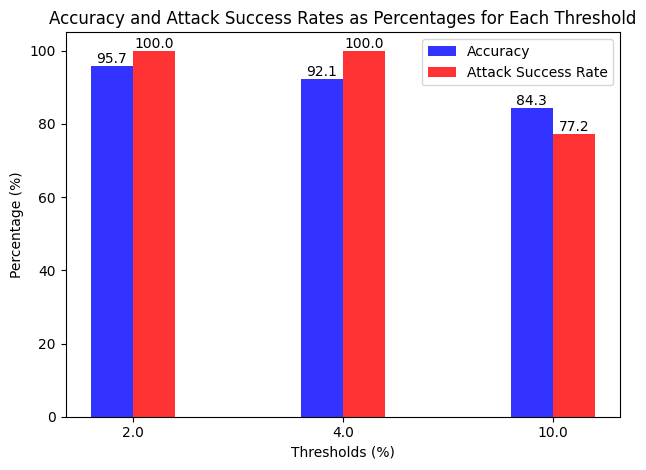

In [169]:
printAccuracyAndAttackSuccessRatesGraph(thresholds_percentages, goodnet_accuracies_percentages, goodnet_attack_success_rates_percentages)

In [170]:
printResultsTable(thresholds_percentages, goodnet_accuracies_percentages, goodnet_attack_success_rates_percentages)

   Threshold (%)  Accuracy (%)  Attack Success Rate (%)
0            2.0     95.744349               100.000000
1            4.0     92.127825                99.984412
2           10.0     84.333593                77.209665


### Showing results for pruned models

In [171]:
pruned_model_accuracies_percentages = [x * 100 for x in pruned_model_accuracies]
pruned_model_attack_success_rates_percentages = [x * 100 for x in pruned_model_attack_success_rates]

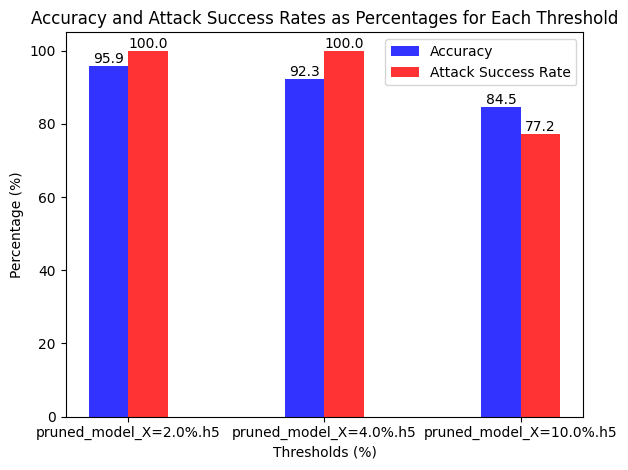

In [172]:
# Now, use your existing functions to print graphs and tables for the pruned models
printAccuracyAndAttackSuccessRatesGraph(pruned_models, pruned_model_accuracies_percentages, pruned_model_attack_success_rates_percentages)

In [173]:
printResultsTable(pruned_models, pruned_model_accuracies_percentages, pruned_model_attack_success_rates_percentages)

             Threshold (%)  Accuracy (%)  Attack Success Rate (%)
0   pruned_model_X=2.0%.h5     95.900234               100.000000
1   pruned_model_X=4.0%.h5     92.291504                99.984412
2  pruned_model_X=10.0%.h5     84.544037                77.209665


### Conclusion

We see that the results for the pruned models and the goodnet models we created are exactly the same. The GoodNet models developed show promising results in both maintaining high accuracy on clean data and effectively detecting backdoored inputs. 